# Forecasting with System of Equation

## Data Import 

In [3]:
import pandas as pd 

df_ts = pd.read_excel("MSTR-Bitcoin (2018-2020).xlsx", index_col=0)

### convert to log return

import numpy as np 
LR_ts = np.log(df_ts / df_ts.shift(1))

### Dropping the NAs
LR_ts = LR_ts.dropna()

In [4]:
import dtale

d = dtale.show(df_ts)
d.open_browser

<bound method DtaleData.open_browser of >

## Vector Autoregression

In [5]:
var_df = LR_ts.iloc[:,0:2]

In [6]:
var_df

,MSTR,Bitcoin
Date,,
2018-01-03,0.002201,0.016522
2018-01-04,0.010031,-0.005179
2018-01-08,0.011268,-0.000743
2018-01-09,0.014146,-0.029085
2018-01-10,-0.015408,-0.000350
...,...,...
2020-08-13,0.025303,0.003559
2020-08-14,-0.006230,0.013254
2020-08-17,0.072784,0.046177


### Test for Stationarity 

Augumented Dickey Fuller Test - ADF Test

H0: The time series is non-stationary
H1: The time series is stationary

In [7]:
#### Function for stationarity
### Import necessary library
from statsmodels.tsa.stattools import adfuller

def adftest(dz):
    
    result = adfuller(dz)
    return result[1]  # Return p-value

#### Check for stationarity

In [8]:
def checkstationary(df):
    for i in df.columns:
        p_val = adftest(df[i])
        if p_val < 0.05:
            print ("stationary")

In [9]:
#### calling the function to check the two series
checkstationary(var_df)

stationary
stationary


As you can see the two series are stationary, we can proceed further to implement VAR model

### LAG Selection

In [10]:
#### Import library for VAR model 
from statsmodels.tsa.api import VAR

def lag_select(dz):
    # Fit a VAR model
    model = VAR(dz)
    lag_selection = model.select_order(maxlags=4)
    return lag_selection.summary()

In [11]:
lag_select(var_df)

c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



,AIC,BIC,FPE,HQIC
0,-13.77,-13.76*,1.046e-06,-13.76*
1,-13.78*,-13.74,1.038e-06*,-13.76
2,-13.77,-13.70,1.045e-06,-13.75
3,-13.77,-13.67,1.049e-06,-13.73
4,-13.76,-13.64,1.056e-06,-13.71


In case of more lags, the number of data points required to fit VAR model would be more. 

In our case we will settle down to choosing "1" Lag



### Fitting VAR

In [12]:
def VAR_fit(dz,lag_order):
    # Fit a VAR model
    model = VAR(dz)
    fitted_model = model.fit(lag_order)
    return fitted_model

In [13]:
#### Calling the VAR function 
var_model_fit = VAR_fit(var_df,1)

c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [14]:
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Jun, 2025
Time:                     22:07:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.7439
Nobs:                     660.000    HQIC:                  -13.7689
Log likelihood:           2681.98    FPE:                1.03121e-06
AIC:                     -13.7848    Det(Omega_mle):     1.02190e-06
--------------------------------------------------------------------
Results for equation MSTR
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000152         0.000820            0.185           0.853
L1.MSTR           -0.082773         0.038706           -2.139           0.032
L1.Bitcoin         0.044281         0.017086            2.592           0

Try to interpret the results

### Diagnostics 

#### serial correlation


In [15]:
 # Fit a VAR model
from statsmodels.stats.stattools import durbin_watson


# Ljung-Box test for autocorrelation in the residuals
def serial_corr(var_fit):
    ser_out = durbin_watson(var_fit.resid)
    return ser_out

In [16]:
#ser_output = serial_corr(var_model_fit,10)
ser_out = serial_corr(var_model_fit)

In [17]:
ser_out

array([2.00605784, 1.99684777])

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

#### Normality of residuals

var_model_fit.test_normality().summary()

## Features of VAR

### Granger Causality

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests

# Granger Causality Tests
def granger_causality_tests(data, variables, max_lag):
    results = {}
    for var1 in variables:
        for var2 in variables:
            if var1 != var2:
                test_result = grangercausalitytests(data[[var1, var2]], max_lag, verbose=False)
                p_values = [round(test[0]['ssr_ftest'][1], 4) for test in test_result.values()]
                results[f"{var2} causes {var1}"] = p_values
    return pd.DataFrame(results, index=[f"Lag {i+1}" for i in range(max_lag)])

print("\nGranger Causality Tests:")
causality_results = granger_causality_tests(var_df, var_df.columns, 1)
print(causality_results)



Granger Causality Tests:
       Bitcoin causes MSTR  MSTR causes Bitcoin
Lag 1               0.0098               0.6858


c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results



In [19]:
grangercausalitytests(var_df[['MSTR', 'Bitcoin']], maxlag=1)  # Tests if Bitcoin causes MSTR
grangercausalitytests(var_df[['Bitcoin', 'MSTR']], maxlag=1)  # Tests if MSTR causes Bitcoin


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7166  , p=0.0098  , df_denom=657, df_num=1
ssr based chi2 test:   chi2=6.7472  , p=0.0094  , df=1
likelihood ratio test: chi2=6.7130  , p=0.0096  , df=1
parameter F test:         F=6.7166  , p=0.0098  , df_denom=657, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1639  , p=0.6858  , df_denom=657, df_num=1
ssr based chi2 test:   chi2=0.1646  , p=0.6849  , df=1
likelihood ratio test: chi2=0.1646  , p=0.6850  , df=1
parameter F test:         F=0.1639  , p=0.6858  , df_denom=657, df_num=1


{np.int64(1): ({'ssr_ftest': (np.float64(0.1638671388103298),
    np.float64(0.685752567847192),
    np.float64(657.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.16461539058571942),
    np.float64(0.6849423030182882),
    np.int64(1)),
   'lrtest': (np.float64(0.16459486503845255),
    np.float64(0.684960891314391),
    np.int64(1)),
   'params_ftest': (np.float64(0.16386713881033185),
    np.float64(0.685752567847192),
    np.float64(657.0),
    1.0)},
   array([[0., 1., 0.]])])}

Reject Null Hypothesis for MSTR causes Bitcoin but
Fail to reject Null Hypothesis for Bitcoin causes MSTR.

### Impulse Response

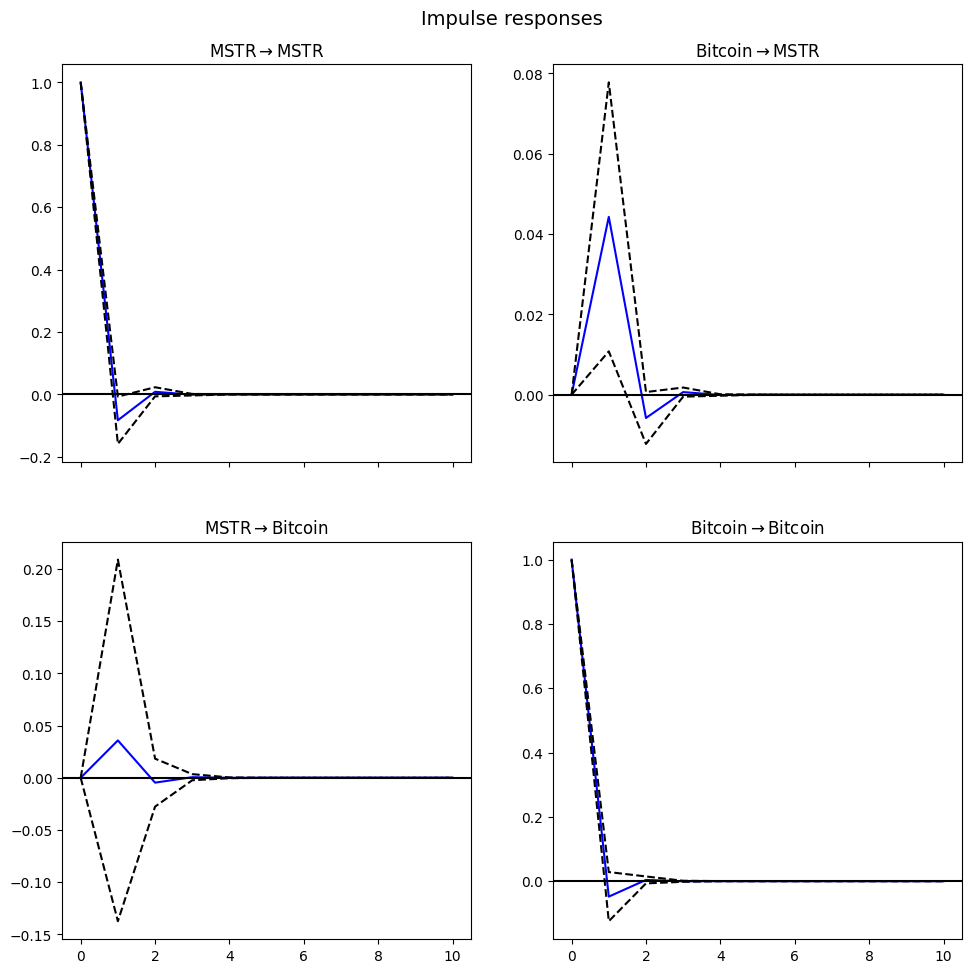

In [20]:
# Impulse Response Function
import matplotlib.pyplot as plt

irf = var_model_fit.irf(10)  # IRF for 10 periods
irf.plot(orth=False)
plt.show()

## Forecasting with the VAR 

In [21]:
# Forecasting using the VAR model
forecast_steps = 5  # Number of steps to forecast
lags = 1

var_model_fit.forecast(var_df.values[-lags:], forecast_steps)

array([[-0.00040455,  0.00060195],
       [ 0.00021182, -0.00044068],
       [ 0.00011463, -0.00036851],
       [ 0.00012588, -0.00037545],
       [ 0.00012464, -0.00037472]])

#### Error in Forecast and its connection with Spillover

In [22]:
def spill_func(var_fit, forecast_steps):
    sigma_u = np.asarray(var_fit.sigma_u)
    sd_u = np.sqrt(np.diag(sigma_u))
    fevd = var_fit.fevd(forecast_steps, sigma_u / sd_u)

    fe = fevd.decomp[:,-1,:]
    fevd_normalized = (fe / fe.sum(1)[:,None] * 100)

    return fevd_normalized

##### Save this 
spill_matrix = spill_func(var_model_fit, forecast_steps)


### Market Interconnectedness and Spillover

In [23]:
spill_df = var_df

lag_order = 1
### Calling the VAR
spill_fit = VAR_fit(spill_df,lag_order)

c:\Users\mayow\Desktop\Spillover MSTR-Bitcoin\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [24]:
#### calling the spill function to create spillover matrix 
forecast_steps = 10
spill_matrix = spill_func(spill_fit, forecast_steps)

In [25]:
spill_matrix

array([[98.9350448 ,  1.0649552 ],
       [ 0.11721284, 99.88278716]])

In [26]:
#### export the output
np.savetxt('spill_1.csv', (spill_matrix), delimiter=',')

In [27]:
type(spill_matrix)

numpy.ndarray

In [ ]:
# Convert numpy ndarray to pandas DataFrame
spill_out = pd.DataFrame(spill_matrix, columns=[f'Column{i+1}' for i in range(spill_matrix.shape[1])])

# Export the DataFrame to an Excel file
spill_out.to_excel('spill_1.xlsx', index=False, engine='openpyxl')

2025-06-27 23:07:55,982 - INFO     - Executing shutdown due to inactivity...
2025-06-27 23:08:08,758 - INFO     - Executing shutdown...
2025-06-27 23:08:08,766 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer
